# Barcodes

In [1]:
# Loading R packages.
suppressMessages(library(DESeq2))
suppressMessages(library(RColorBrewer))
suppressMessages(library(pheatmap))
suppressMessages(library(ggplot2))
suppressMessages(library(ggrepel))
suppressMessages(library(viridis))
suppressMessages(library(EnhancedVolcano))
suppressMessages(library(fgsea))
suppressMessages(library(scales))
suppressMessages(library(grid))
suppressMessages(library(gridExtra))
suppressMessages(library(forcats))
suppressMessages(library(Biostrings))
suppressMessages(library(ggseqlogo))
suppressMessages(library(seqinr))

In [ ]:
# # Original barcode code and source.

# # https://github.com/patrickbarks/cantempr/tree/master/R
# # https://github.com/patrickbarks/cantempr/blob/master/R/sysdata.rda

# load("/Users/dara6367/sysdata.rda")
# cantemp <- cantemp[cantemp$station == "TORONTO",]

# cantemp_fetch <- function(interval = "annual") {
  
#   if (!interval %in% c("monthly", "seasonal", "annual", "all")) {
#     stop("Argument interval must be one 'monthly', 'seasonal', 'annual', or 'all'")
#   }
  
#   dat <- cantemp
  
#   seasons <- c("Winter", "Spring", "Summer", "Autumn")
#   months <- month.abb
  
#   if (interval == "monthly") {
#     dat <- dat[!dat$interval %in% c("Annual", seasons),]
#   } else if (interval == "seasonal") {
#     dat <- dat[!dat$interval %in% c("Annual", months),]
#   } else if (interval == "annual") {
#     dat <- dat[!dat$interval %in% c(seasons, months),]
#   }
  
#   # reset rownames
#   rownames(dat) <- seq_len(nrow(dat))
  
#   return(dat)
# }

# cantemp_barcode <- function(data,
#                             scale_col_low = "white",
#                             scale_col_mid = "bisque3",
#                             scale_col_high = "midnightblue",
#                             scale_col_na = "grey50",
#                             scale_name = NULL,
#                             scale_breaks = 5,
#                             scale_digits = 1,
#                             x_breaks = waiver()) {
  
#   ggplot(data, aes_string("year", 1, fill = "temp")) +
#     geom_tile() +
#     scale_x_continuous(expand = c(0, 0), breaks = x_breaks) +
#     scale_y_continuous(expand = c(0.02, 0)) +
#     scale_fill_gradient2(low = scale_col_low,
#                          mid = scale_col_mid,
#                          high = scale_col_high,
#                          na.value = scale_col_na,
#                          midpoint = mean(data$temp, na.rm = TRUE),
#                          name = scale_name,
#                          breaks = function(x) seq(x[1], x[2], length.out = scale_breaks),
#                          labels = function(x) paste(formatC(x, format = "f", digits = scale_digits), "\u00B0C")) +
#     theme_void() +
#     theme(axis.text.x = element_blank(), legend.position = "none")
# }

                         
# clim_annual <- cantemp_fetch(interval = "annual")
# options(repr.plot.width = 6.6, repr.plot.height = 1)
# cantemp_barcode(clim_annual)

                         
# options(repr.plot.width = 6.6, repr.plot.height = 1)
# ggplot(clim_annual, aes_string("year", 1, fill = "temp")) +
#     geom_tile() +
#     scale_fill_gradient2(low = "white",
#                          mid = "bisque3",
#                          high = "midnightblue",
#                          na.value = "grey50",
#                          midpoint = mean(clim_annual$temp, na.rm = TRUE),
#                          name = NULL) +
#     theme_void() +
#     theme(axis.text.x = element_blank(), legend.position = "none")

## Motif instances at genes TSS

In [2]:
# Loads in FASTA file, and makes it a data frame.

fastaFile <- readDNAStringSet("/scratch/Users/dara6367/PRO-seq_interspecies-nutlin/Bidirectional-Flow/Human/fimo/RNA-Human-TSS.fa")
seqNames = names(fastaFile)
sequence = paste(fastaFile)
fastaSequences <- data.frame(sequence)
rownames(fastaSequences) <- seqNames
fastaSequences$sequence <- as.character(fastaSequences$sequence)

# Loads in FIMO file, and makes it a data frame. Adds the middle motif coordinates.
fimoTable <- read.table("/scratch/Users/dara6367/PRO-seq_interspecies-nutlin/Bidirectional-Flow/Human/fimo/RNA-Human-TSS_TP53_M06704_1.1e-5.txt", 
                        header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
fimoTable$middle <- fimoTable$start + 10
colnames(fimoTable) <- c("motif_id","motif_alt_id","sequence_name","start","stop","strand","score","p_value","q_value","matched_sequence","middle")

# Extracts the motif instance sequence from the FASTA file.
# If the motif instance is in the negative strand, then it reverse complements it before storing it.
for(entry in seq(1:dim(fimoTable)[1])) {
   if(fimoTable[entry,"strand"] == "+") {
            fimoTable[entry,"matched_sequence"] <- subseq(fastaSequences[entry,"sequence"], 
                                                  start = fimoTable[entry,"start"], 
                                                  end = fimoTable[entry,"stop"]) }
    if(fimoTable[entry,"strand"] == "-") {
            MotifInstance <- subseq(fastaSequences[entry,"sequence"], 
                                                  start = fimoTable[entry,"start"], 
                                                  end = fimoTable[entry,"stop"])
            fimoTable[entry,"matched_sequence"] <- paste(toupper(rev(comp(s2c(MotifInstance)))), collapse = "") }
 }

# # Filters out fimo motifs by p-value.
# fimoTable <- fimoTable[fimoTable$p_value < 0.0000001,]

# Initializes with zeroes a data frame that will contain the middle points of found motifs.
motifPositions <- data.frame(matrix(0, ncol = 2, nrow = 3000))
colnames(motifPositions) <- c("position","counts")
motifPositions$position <- seq(1:3000)
rownames(motifPositions) <- seq(1:3000)

# motifPositions[1000,"counts"] <- 1
# motifPositions[1500,"counts"] <- 1
# motifPositions[2500,"counts"] <- 1

# Records the location of each motif instance in the motifPositions data frame.
for(i in seq(1:dim(fimoTable)[1])) {
    motifPositions[fimoTable[i,"middle"],"counts"] <- motifPositions[fimoTable[i,"middle"],"counts"] + 1 }

# Collapses positions into 50bp bins.
motifPositionsBins <- data.frame(matrix(0, ncol = 2, nrow = 60))
colnames(motifPositionsBins) <- c("positionBins","counts")
motifPositionsBins$positionBins <- seq(from = 50, to = 3000, by = 50)
rownames(motifPositionsBins) <- seq(from = 50, to = 3000, by = 50)

for(bin in seq(from = 50, to = 3000, by = 50)) {
    motifPositionsBins[motifPositionsBins$position == bin,"counts"] <- sum(motifPositions[seq(from = bin-49, to = bin),"counts"]) }

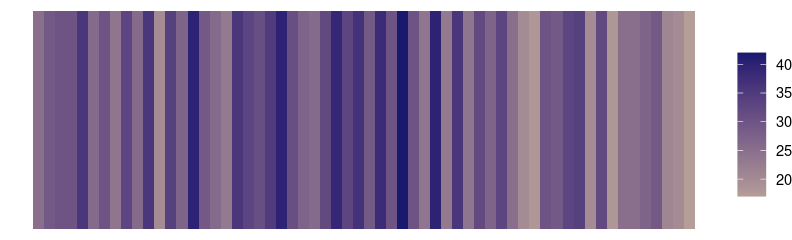

In [3]:
# Plots barcode.
options(repr.plot.width = 6.6, repr.plot.height = 2)
ggplot(motifPositionsBins, aes_string("positionBins", 1, fill = "counts")) +
    geom_tile() +
    scale_fill_gradient2(low = "white",
                         mid = "bisque3",
                         high = "midnightblue",
                         na.value = "grey50",
                         midpoint = (max(motifPositionsBins$counts)-min(motifPositionsBins$counts))/2,
                         name = NULL) +
    theme_void() +
    theme(axis.text.x = element_blank())

# legend.position = "none"

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


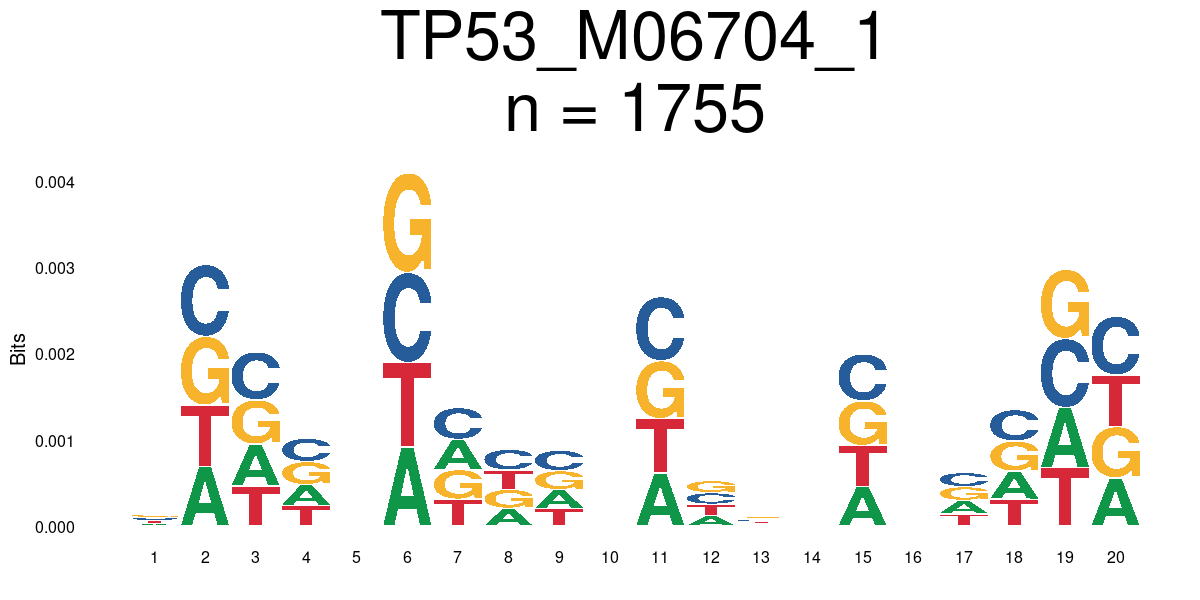

In [8]:
# Plots motif logo.

# https://omarwagih.github.io/ggseqlogo/
# https://www.bioconductor.org/packages/devel/bioc/vignettes/motifStack/inst/doc/motifStack_HTML.html

fimoTablePos <- fimoTable[fimoTable$strand == "+",]
fimoTableNeg <- fimoTable[fimoTable$strand == "-",]

options(repr.plot.width = 10, repr.plot.height = 5)

# Lists available font types: list_fonts(F)
ggseqlogo(fimoTable$matched_sequence, 
          method = "bits", 
          font = "helvetica_bold") +
ggtitle(paste0("TP53_M06704_1\nn = ",dim(fimoTable)[1])) +
theme(plot.title = element_text(size = 40, hjust = 0.5))

## TP53 instances genome wide

In [9]:
# Loads in FIMO file, and makes it a data frame. Adds the middle motif coordinates.
fimoTable <- read.table("/scratch/Users/dara6367/fimo/Human/hg38-best_curated_Human-p1e-6/TP53_M06704_1.bed", 
                        header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
colnames(fimoTable) <- c("motif_id","motif_alt_id","sequence_name","start","stop","strand","score","p_value","q_value","matched_sequence")

# If the motif instance is in the negative strand, then it reverse complements it before storing it.
for(entry in seq(1:dim(fimoTable)[1])) {
   if(fimoTable[entry,"strand"] == "+") {
            fimoTable[entry,"matched_sequence"] <- toupper(fimoTable[entry,"matched_sequence"]) }
    if(fimoTable[entry,"strand"] == "-") {
            fimoTable[entry,"matched_sequence"] <- paste(toupper(rev(comp(s2c(fimoTable[entry,"matched_sequence"])))), collapse = "") }
}

# Sorts table by decreasing score.
fimoTable <- fimoTable[order(fimoTable$score, decreasing = TRUE),]

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


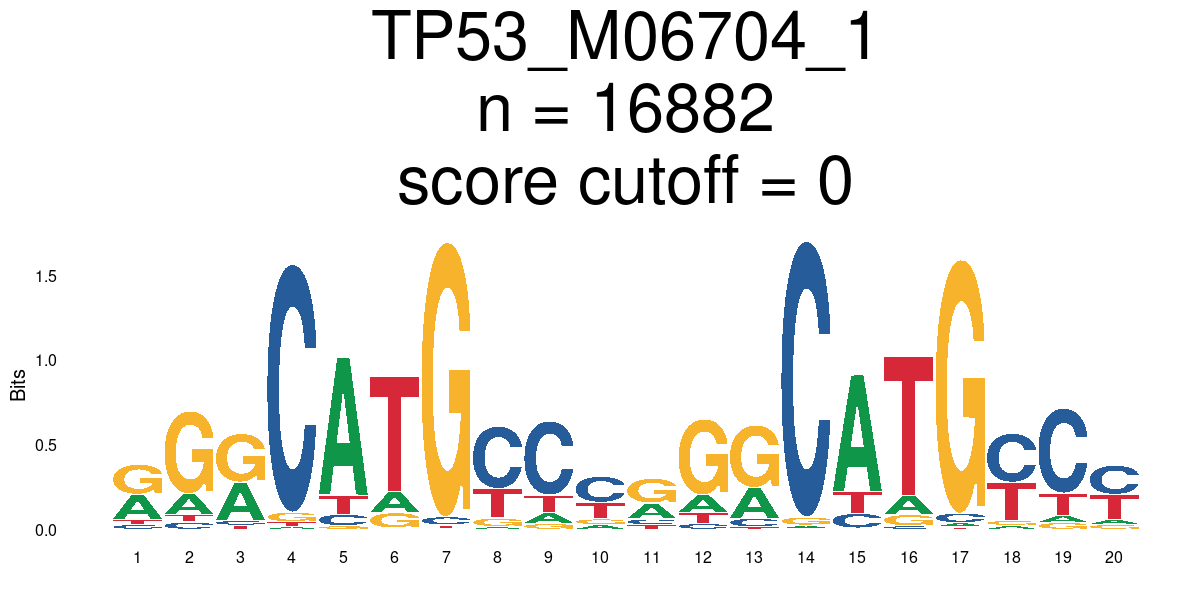

In [10]:
# Plots motif logo.

# https://omarwagih.github.io/ggseqlogo/
# https://www.bioconductor.org/packages/devel/bioc/vignettes/motifStack/inst/doc/motifStack_HTML.html

# Filters out fimo motifs by score.
thres <- 0
fimoTableFilt <- fimoTable[fimoTable$score > thres,]

fimoTableFiltPos <- fimoTableFilt[fimoTableFilt$strand == "+",]
fimoTableFiltNeg <- fimoTableFilt[fimoTableFilt$strand == "-",]

options(repr.plot.width = 10, repr.plot.height = 5)

# Lists available font types: list_fonts(F)
ggseqlogo(fimoTableFilt$matched_sequence, 
          method = "bits", 
          font = "helvetica_bold") +
ggtitle(paste0("TP53_M06704_1\nn = ",dim(fimoTableFilt)[1],"\nscore cutoff = ",thres)) +
theme(plot.title = element_text(size = 40, hjust = 0.5))

## Logos at conservation bins

In [17]:
# Loading FIMO motifs at all standard-10 gene TSS.

# Loads in FIMO file, and makes it a data frame. Adds the middle motif coordinates.
fimoTable <- read.table("/scratch/Users/dara6367/PRO-seq_interspecies-nutlin/Bidirectional-Flow/Human/fimo/RNA-Human-TSS_TP53_M06704_1.1e-6.txt", 
                        header = TRUE, sep = "\t", fill = TRUE, stringsAsFactors = FALSE, na.strings = "")
fimoTable$middle <- fimoTable$start + 10
colnames(fimoTable) <- c("motif_id","motif_alt_id","sequence_name","start","stop","strand","score","p_value","q_value","matched_sequence","middle")